In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from collections import Counter
import math

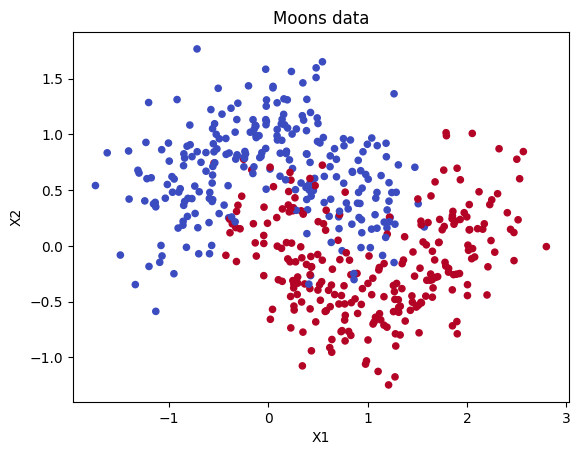

In [44]:
data = np.load('moons_data.npz')
X = data['X']
y = data['y']

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="coolwarm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Moons data")
plt.show()

In [45]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion="gini", percent_of_features=None):
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None
        self.percent_of_features = percent_of_features

    def fit(self, X, y, w):
        self.tree = self.grow_tree(X, y, w)

    def grow_tree(self, X, y, w, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(set(y))

        # regularization - stop if max_depth is reached or if there is only one label
        if (depth >= self.max_depth or num_labels == 1):
            class_weights = {}
            for c in np.unique(y):
                class_weights[c] = np.sum(w[y == c])
            majority_class = max(class_weights, key=class_weights.get)
            return {"label": majority_class}
        
        number_of_features = int(num_features * self.percent_of_features)
        features_index_to_consider = np.random.choice(num_features, number_of_features, replace=False)
        best_split = self.best_split(X, y, w, features_index_to_consider)

        if best_split["gain"] == 0:
            class_weights = {}
            for c in np.unique(y):
                class_weights[c] = np.sum(w[y == c])
            majority_class = max(class_weights, key=class_weights.get)
            return {"label": majority_class}

        left = self.grow_tree(
            best_split["X_left"],
            best_split["y_left"],
            best_split["w_left"],
            depth + 1,
        )
        right = self.grow_tree(
            best_split["X_right"],
            best_split["y_right"],
            best_split["w_right"],
            depth + 1,
        )

        return {
            "feature": best_split["feature"],
            "threshold": best_split["threshold"],
            "left": left,
            "right": right,
        }

    # Find the best split for the current node in the tree with respect to one feature
    # input: X, y, num_features
    # output: split -> dictionary containing the feature, threshold, gain, X_left, y_left, X_right, y_right
    def best_split(self, X, y, w, features_index_to_consider):
        best_gain = -1
        split = {
            "feature": None,
            "threshold": None,
            "gain": None,
            "X_left": None,
            "y_left": None,
            "w_left": None,
            "X_right": None,
            "y_right": None,
            "w_right": None,
        }
        
        ########## Your code goes here ##########
        
        for feature in features_index_to_consider:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain, X_left, y_left, w_left, X_right, y_right, w_right = self.split(X, y, w, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split["feature"] = feature
                    split["threshold"] = threshold
                    split["gain"] = gain
                    split["X_left"] = X_left
                    split["y_left"] = y_left
                    split["w_left"] = w_left
                    split["X_right"] = X_right
                    split["y_right"] = y_right
                    split["w_right"] = w_right
                    
        ###########################################
        

        return split

    # split the data into two regions based on the feature and threshold and computes the information gain
    def split(self, X, y, w, feature, threshold):
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        X_left, y_left, w_left = X[left_idx], y[left_idx], w[left_idx]
        X_right, y_right, w_right = X[right_idx], y[right_idx], w[right_idx]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0, X_left, y_left, w_left, X_right, y_right, w_right

        gain = self.information_gain(y, w, y_left, w_left, y_right, w_right)

        return gain, X_left, y_left, w_left, X_right, y_right, w_right

    def information_gain(self, y, w, y_left, w_left, y_right, w_right):
        total_weight = np.sum(w)
        weight_left = np.sum(w_left)
        weight_right = np.sum(w_right)

        if self.criterion == "gini":
            gain = self.gini(y, w) - (
                (weight_left / total_weight) * self.gini(y_left, w_left)
                + (weight_right / total_weight) * self.gini(y_right, w_right)
            )
        else:
            gain = self.entropy(y, w) - (
                (weight_left / total_weight) * self.entropy(y_left, w_left)
                + (weight_right / total_weight) * self.entropy(y_right, w_right)
            )

        return gain

    # Compute the gini impurity
    def gini(self, y, w):

        gini_impurity = None

        # The class probabilities should be calculated as the sum of the sample weights for each class normalized by the total sum of all weights

        ########## Your code goes here ##########

        class_counts = Counter(y)
        total_samples = len(y)
        gini_impurity = 1 - sum((count / total_samples) ** 2 for count in class_counts.values())    
        
        ###########################################

        return gini_impurity

    # Compute the entropy
    def entropy(self, y, w):

        entropy_value = None

        # The class probabilities should be calculated as the sum of the sample weights for each class normalized by the total sum of all weights

        ########## Your code goes here ##########

        class_counts = Counter(y)
        total_samples = len(y)
        entropy_value = 0
        for count in class_counts.values():
            prob = count / total_samples
            entropy_value -= prob * np.log2(prob) 

        ###########################################

        return entropy_value
    
    # Predict for a vector of inputs
    def predict(self, X):
        return np.array([self.predict_single(inputs, self.tree) for inputs in X])

    # Predict for a single input
    def predict_single(self, inputs, tree):
        if "label" in tree:
            return tree["label"]
        feature = tree["feature"]
        threshold = tree["threshold"]
        if inputs[feature] <= threshold:
            return self.predict_single(inputs, tree["left"])
        else:
            return self.predict_single(inputs, tree["right"])



In [60]:
class AdaBoost():

    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []  # To store alpha values
        self.models = []  # To store weak classifiers

    def fit(self, X, y):
        n_samples, _ = X.shape

        # Initialize weights equally

        ########## Your code goes here ##########
        
        w = np.ones(n_samples) / n_samples
        
        #########################################
        
        # Convert y to {+1, -1} for compatibility. Hint: Use np.where
        ########## Your code goes here ##########
                
        y = np.where(y == 0, -1, 1)

        #########################################

        for _ in range(self.n_estimators):

            # Implement the Adaboost algorithm using Decision Stumps as weak learners
            
            ########## Your code goes here ##########

            # Create a weak learner
            tree = DecisionTree(max_depth=1, criterion="gini", percent_of_features=0.5)
            tree.fit(X, y, w)
            self.models.append(tree)
    
            # Calculate error rate
            y_pred = tree.predict(X)
            error = np.sum(w * (y_pred != y)) / np.sum(w)
            
            # Calculate alpha (importance of the weak learner)
            alpha = 0.5 * np.log((1 - error) / error)
            self.alphas.append(alpha)
            
            # Update weights
            w = w * np.exp(-alpha * y * y_pred)

            # Normalize weights
            w = w / np.sum(w)

            #########################################

    def predict(self, X):
        # Compute the weighted sum of weak classifiers

        pred = None

        ########## Your code goes here ##########
        
        pred = np.zeros(X.shape[0])
        for alpha, tree in zip(self.alphas, self.models):
            pred += alpha * tree.predict(X)
        pred = np.sign(pred)
        
        #########################################
        return pred

    

In [1]:
ada_boost = AdaBoost(n_estimators=100)
ada_boost.fit(X, y)

NameError: name 'AdaBoost' is not defined

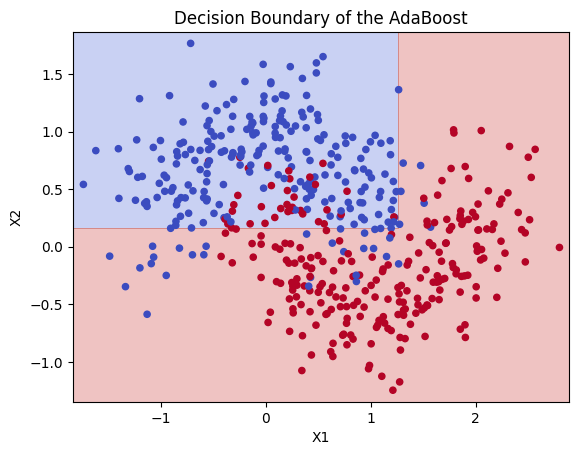

In [62]:
def plot_decision_boundaries(tree, X, y, title=""):
    # Define bounds of the plot
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create a grid of points with a small step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Use the classifier to predict the class at each grid point
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot the contours
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="coolwarm")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()

plot_decision_boundaries(ada_boost, X, y, title="Decision Boundary of the AdaBoost")
